# DETAILED MODEL-FITTING WITH MANY OBSERVATIONAL CONSTRAINTS

## A photoionization model for IC418

Consider the planetary nebula IC 418. A detailed photoionization model of it has been published by Morisset & Georgiev (2009). 
The proposed exercise is not to reproduce this model exactly but rather to show  the different steps to reach an acceptable solution and keep a critical eye on the results. 
The following observational constraints are considered:

* HST WFPC observations  in  H$\alpha$, [NII] and [OIII] fiters (find the 3-colour image on the internet and examine it)
* Total reddening-corrected H$\beta$ flux 
* Angular diameter 
* The stellar spectrum
* A high resolution, deep optical spectrum within a slit 
* Ultraviolet spectra obtained with IUE
* Infrared spectra 



### Compute the starting model abundances using the direct method.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pyneb as pn
import pyCloudy as pc
from pyCloudy.utils.misc import make_mask, convert_label
from pyCloudy.utils.astro import conv_arc
pc.config.cloudy_exe = 'cloudy.exe'
models_dir = '../../Models/'

### Build a model with a density distribution reproducing the observed H$\alpha$ surface brightness distribution and using the stellar model presented in Morisset & Georgiev (2009), which fits the atmospheric stellar properties. For the fitting procedure, compare the observed line intensities with those obtained by the model in the corresponding apertures. Try to find a model which reproduces all the line intensities within their respective error bars.

In [2]:
class In(object):
    
    def __init__(self, name):
        """
        Defining the parameters of the model
        """
        
        self.model_name = name
        self.r_in = 16.09
        # Here we use a user-defined double gaussisn
        self.dlaw_params = [3, 2850. , 5256.6 , 16.28 , 15.96 , 9500.0 , 17.02 , 16.46]
        self.ff = 1.0
        self.distance = 1.25
        self.abunds = {'He':-0.92, 'C':-3.10, 'N':-4.00, 'O':-3.4, 'Ne':-4.0, 'Mg':-4.95,
                       'Si':-4.90, 'S':-5.35, 'Cl':-7.00, 'Ar':-5.8, 'Fe':-7.40}
        self.grains_type = ['orion graphite', 'orion silicate']
        self.grains = [0.2, 0.2]
        self.Q0 = 47.5
        self.SED = 'BB' # STAR or BB
        self.Teff = 39500.
        self.options = ('no molecules',
                        'no level2 lines',
                        'no fine opacities',
                        'element limit off -8',
                        )

        
    def print_model(self):
        """
        Preparing and printing the Cloudy input file
        """
        model = pc.CloudyInput(self.model_name)
        model.set_radius(self.r_in)
        model.set_dlaw(self.dlaw_params, self.ff)
        model.set_distance(self.distance)
        model.set_abund(ab_dict = self.abunds)
        for grains, grains_type in zip(self.grains, self.grains_type):
            model.set_grains('{0} {1}'.format(grains_type, grains))
        if self.SED == 'STAR':
            model.set_star('table star "mod103.mod"', 39390, 'q(H)', self.Q0)
        elif self.SED == 'BB':
            model.set_BB(Teff=self.Teff, lumi_unit='q(H)', lumi_value=self.Q0)
        else:
            pc.log_.error('unknown SED value: {0}'.format(self.SED))
        model.read_emis_file('../Data/ic418N_c17.lines', N_char=14)
        model.set_iterate(0)
        model.set_sphere()
        model.set_other(self.options)
        model.print_input(to_file = True, verbose = False)
        self.model = model
        
    def run_model(self):
        self.model.run_cloudy()


In [3]:
model_name = 'IC418_BB'

In [4]:
Min = In('{0}/{1}'.format(models_dir, model_name))
# Here you can change things in the model before writing the input file
# Example:
# run a Blackbody model
Min.Teff = 39500.
Min.SED = 'BB'
Min.print_model()
Min.run_model()

In [5]:
M = pc.CloudyModel('{0}/{1}'.format(models_dir, model_name))

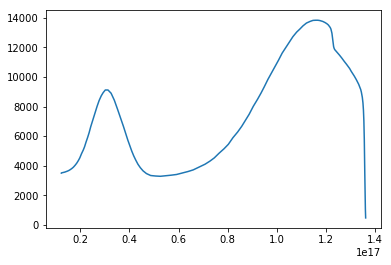

In [6]:
plt.plot(M.radius, M.ne)

In [7]:
model_name = 'IC418_CMF'

In [8]:
Min.model_name = '{0}/{1}'.format(models_dir, model_name)
Min.SED = 'STAR'
Min.print_model()
Min.run_model()

In [9]:
class Out(object):
    
    def __init__(self, name):
        """
        Creating an object to manage the Cloudy output and compare to the observations
        """

        self.model = pc.CloudyModel(name)
        self.set_3D(use=False)
        self.m3d = None
        self.mask = None
        self.profile_defined = False
        self.dim_3D = 101
        self.mask_ap_center = (0., 3.5)
        self.mask_ap_size = (12., 1)
        # define a RedCorr object
        self.RC = pn.RedCorr(E_BV=0.26, R_V=3.6, law='F99')

    def read_obs(self):
        self.obs = np.genfromtxt('../Data/ic418N_c17.lines', dtype=["U13","float","int"],
                            delimiter=[13,10,1], names=['label', 'i_obs', 'obs'])
        # Convert the Cloudy labels into pyCloudy labels
        self.obs['label'] = [convert_label(l) for l in self.obs['label']]
        # print(self.obs)
        self.IR_cross_calib_done = False
        self._cross_calibIR()
        self.UV_cross_calib_done = False
        self._cross_calibUV()

    def print_obs(self):
        for obs in self.obs:
            print('{0} : {1}'.format(obs['label'], obs['i_obs']))

    def _cross_calibIR(self):
        """
        Cross calibration of the IR line intensities, using the theoretical value of 4.05mu/100.Hbeta, as given by the model
        This method is not supposed to be used by the user (it begins with _).
        """
        if self.IR_cross_calib_done:
            pn.log_.warn('Are you trying to cross_calib data that are already calibrated???')
            return
        theo_ratio = self.get_emis('H__1_405116M') / self.get_emis('H__1_486136A') * 100
        i_4051 = (self.obs['label'] == 'H__1_405116M')
        norm = theo_ratio / self.obs['i_obs'][i_4051]
        i_IR = (self.obs['obs'] == 1)
        self.obs['i_obs'][i_IR] *= norm
        self.IR_cross_calib_done = True
        pc.log_.message('Correcting {0} IR lines so that 4.05mu/100.Hbeta = {1}, using norm={2}'.format(i_IR.sum(), 
                                                                                                        theo_ratio, 
                                                                                                        norm))

    def _cross_calibUV(self):
        """
        Cross calibration of the UV line intensities, using the theoretical value of [OII] 2471/7323, as given by the model.
        This method is not supposed to be used by the user (it begins with _).
        """        
        if self.UV_cross_calib_done:
            pn.log_.warn('Are you trying to cross_calib data that are already calibrated???')
            return
        theo_ratio = self.get_emis('BLND_247100A') /self.get_emis('BLND_732300A')
        i_2471 = (self.obs['label'] == 'BLND_247100A')
        i_7323 = (self.obs['label'] == 'BLND_732300A')
        norm = theo_ratio * self.obs['i_obs'][i_7323] / self.obs['i_obs'][i_2471]
        i_UV = (self.obs['obs'] == 2)
        self.obs['i_obs'][i_UV] *= norm
        self.UV_cross_calib_done = True
        pc.log_.message('Correcting {0} UV lines so that [OII] 2471/7323 = {1}, using norm={2}'.format(i_UV.sum(), 
                                                                                                       theo_ratio, 
                                                                                                       norm))
        
    def set_3D(self, use=False):
        if use:
            # already in 3D mode, nothing to do!
            if self.use_3D:
                return
            # create the 3D model
            # Very important to have center = True for the line profiles.
            self.m3d = pc.C3D(self.model, dims = self.dim_3D, center = True, n_dim = 1)
            self.use_3D = True
            # need to read the observations as the IR and UV cross-calibration depends on the apertures
            self.read_obs()
        else:
            self.use_3D = False
            self.read_obs()
            
    def get_emis(self, label):
        """
        Return the line emission. 
        If use_3D is set, the 3D model is used, otherwise the 1D
        """
        # test if we are in the 3D case or not
        if self.use_3D:
            # look for the observation type, according to the "label" parameter
            # in the table obs, look for the column 'obs'
            obs_type = self.obs['obs'][(self.obs['label'] == label)][0]
            if obs_type == 0: # this is the observation type for which a mask is required
                # the mask is already defined?
                if self.mask is None:
                    # if not, do it!
                    self.mask = self.get_mask()
                mask = self.mask
            else:
                # if obs != 1, the observation is of the full object, no need for a mask
                mask = 1.  
            return ((self.m3d.get_emis(label)).sum(axis=1) * mask).sum()
        else:
            return self.model.get_emis_vol(label)
        
    def get_mask(self, seeing = None):
        """
        Return a mask to apply to a 2D projection of a 3D models, to reproduce an aperture
        """
        self.set_3D(use=True)
        # convert the sizes in arcsec
        x_arc = pc.astro.conv_arc(dist_proj = self.m3d.cub_coord.x_vec, dist = self.model.distance)
        y_arc = pc.astro.conv_arc(dist_proj = self.m3d.cub_coord.y_vec, dist = self.model.distance)
        # produce two 2D tables for X and Y
        X, Y = np.meshgrid(x_arc, y_arc)
    
        mask = make_mask(X, Y, ap_center = self.mask_ap_center, ap_size = self.mask_ap_size, seeing = seeing)
        return mask

    def print_res(self):
        """
        Print the results
        """
        # Rout of the photoionization model
        r_out_arcsec = conv_arc(dist = self.model.distance, dist_proj = np.max(self.model.r_out))
        print('Outer radius in arcsec: {0:.2f}'.format(r_out_arcsec))
        # Hbeta total absolute intensity at earth (distance dependant)
        Hbeta_tot = self.model.get_emis_vol('H__1_486136A', at_earth=True)
        # print the reddened Hbeta intensity, to be compared to the observed value of -9.57
        print('Hbeta Abs   :  -9.57   {0:5.2f}'.format(np.log10(Hbeta_tot / self.RC.getCorr(4861.))))
        
        # the following prints line intensities, through an aperture or not, depending on the
        # value of the use_3D parameter.
        Hbeta = self.get_emis('H__1_486136A')
        for obs in self.obs:
            model = self.get_emis(obs['label']) / Hbeta * 100
            print('{0} : {1:6.2f} {2:6.2f} {3:6.2f}'.format(obs['label'], obs['i_obs'], model, 
                                                            (model-obs['i_obs'])/obs['i_obs']))
    
    def plot_im(self, label = 'H__1_486136A', axis=1, plot_mask=True, ax=None):
        """
        Plot an image projected on an axis
        Parameters:
            - label: which emission line image to plot
            - axis: the projection axis
            - plot_mask: if True (default). overplot the mask
        """
        if ax is None:
            f, ax = plt.subplots()
        else:
            f =plt.gcf()
        self.set_3D(use=True)
        # the size of the image in arcsec is determined from the distance of the object and 
        # the maximum of the x_vec variable
        max_x = conv_arc(dist = self.model.distance, dist_proj = np.max(self.m3d.cub_coord.x_vec))
        plt.imshow((self.m3d.get_emis(label)).sum(axis=axis), extent=[-max_x, max_x, -max_x, max_x])
        if plot_mask:
            if self.mask is None:
                self.mask = self.get_mask()
            ax.contour(self.mask,levels = [0.5], colors = 'black', linestyles='-', 
                        extent=[-max_x, max_x, -max_x, max_x])
            ax.contour(self.mask,levels = [0.1, 0.9], colors = 'black', linestyles='--', 
                        extent=[-max_x, max_x, -max_x, max_x])
        
    def plot_3col(self, list_emis = ['N__2_654805A', 'O__3_500684A', 'H__1_486136A'], ax=None):
        """
        plot a 3-colors image, using the list_emis references for RGB channels.
        """
        if ax is None:
            f, ax = plt.subplots()
        else:
            f = plt.gcf()
        self.set_3D(use=True)
        # the size of the image in arcsec is determined from the distance of the object and 
        # the maximum of the x_vec variable
        max_x = conv_arc(dist = self.model.distance, dist_proj = np.max(self.m3d.cub_coord.x_vec))
        ax.imshow(self.m3d.get_RGB(list_emis), extent=[-max_x, max_x, -max_x, max_x])
        
    def define_profiles(self, size_spectrum = 21, vel_max = 50., v_turb = 5., vel_params = [0., 10, 10]):
        """
        Define the line profiles by configuring the profile based on a polynomial law.
        """
        self.set_3D(use=True)
        if self.mask is None:
            self.mask = self.get_mask()
        self.m3d.set_velocity(velocity_law = 'poly', params = vel_params)
        self.m3d.config_profile(size_spectrum = size_spectrum, vel_max = vel_max, 
                                v_turb = v_turb, profile_function = 'gaussian')
        self.profile_defined = True
        
    def plot_profile(self, x_pos = None, y_pos=None, legend=True, ax=None, 
                     use_mask=False, title=None, **kwargs):
        """
        plot the line profiles of Hbeta, [NII] and [OIII] at a given position (x_pos, y_pos).
        Arguments:
            - x_pos, y_pos: position at which the line are extracted. If None, the center of the image is used.
            - legend: If True (default), plot the legend.
            - Any other argument is passed to the 3 plots (e.g. linestyle)
        """
        if not self.profile_defined:
            pc.log_.error('Profile not defined!')
            return
        if ax is None:
            f, ax = plt.subplots()
        else:
            f = plt.gcf()
        self.set_3D(use=True)
        if x_pos is None:
            x_pos = int(self.dim_3D/2)
        if y_pos is None:
            y_pos = int(self.dim_3D/2)
        X = self.m3d.vel_tab
        if use_mask:
            Y = ((self.m3d.get_profile('H__1_486136A', axis='x') * self.get_mask()).sum(axis=1)).sum(axis=1)
        else:
            Y = self.m3d.get_profile('H__1_486136A', axis='x')[:,x_pos,y_pos] * 5    
        ax.plot(X, Y, label = r'H$\beta$', **kwargs)
        if use_mask:
            Y = ((self.m3d.get_profile('N__2_658345A', axis='x') * self.get_mask()).sum(axis=1)).sum(axis=1)
        else:
            Y = self.m3d.get_profile('N__2_658345A', axis='x')[:,x_pos,y_pos] * 5  
        ax.plot(X, Y, label = r'[NII]$\lambda$6584', **kwargs)
        if use_mask:
            Y = ((self.m3d.get_profile('O__3_500684A', axis='x') * self.get_mask()).sum(axis=1)).sum(axis=1)
        else:
            Y = self.m3d.get_profile('O__3_500684A', axis='x')[:,x_pos,y_pos]    
        ax.plot(X, Y, label = r'[OIII]$\lambda$5007', **kwargs)
        if legend:
            ax.legend()
        if title is not None:
            ax.set_title(title)
        
    def plot_cont(self, axes=None):
        
        if axes is None:
            f, axes = plt.subplots(2, 1)
        else:
            f = plt.gcf()
        axes[0].plot(self.model.get_cont_x('eV'), self.model.get_cont_y(cont='incid', unit='esA'))
        axes[0].set_xlim(10, 54)
        axes[0].set_xlabel('Energy (eV)')
        axes[0].set_ylabel('erg.s-1.A-1')
        
        axes[1].loglog(self.model.get_cont_x('Ang'), self.model.get_cont_y(cont='diffout', unit='Jy'))
        axes[1].set_xlim(1e3, 1e6)
        axes[1].set_xlabel('Wavelength (A)')
        axes[1].set_ylabel('Jy')
        f.tight_layout()

In [10]:
# reading the outputs, 
# reading the observations,
# doing the cross_calibration of the UV and IR relative to the optical, using the model results

# The 2 previous models are read:
MoutBB = Out('{0}/IC418_BB'.format(models_dir))
MoutCMF = Out('{0}/IC418_CMF'.format(models_dir))

In [11]:
MoutBB.print_res()

Outer radius in arcsec: 7.28
Hbeta Abs   :  -9.57   -9.54
H__1_383540A :   9.49   7.55  -0.20
H__1_397009A :  16.90  16.19  -0.04
H__1_410176A :  24.80  26.23   0.06
H__1_434094A :  44.80  47.20   0.05
H__1_486136A : 100.00 100.00   0.00
H__1_656285A : 312.00 280.05  -0.10
HE_1_447149A :   4.49   0.68  -0.85
HE_1_587564A :  13.67  11.67  -0.15
HE_1_667815A :   3.87   3.10  -0.20
C__1_872713A :   0.03   0.01  -0.74
C__2_426700A :   0.57   0.54  -0.06
N__1_519790A :   0.20   0.04  -0.81
N__1_520026A :   0.12   0.02  -0.79
BLND_575500A :   2.76   2.05  -0.26
N__2_654805A :  53.60  48.42  -0.10
N__2_658345A : 162.90 142.73  -0.12
O__1_557734A :   0.03   0.02  -0.16
O__1_630030A :   2.17   1.05  -0.52
O__2_372603A : 123.80  85.11  -0.31
O__2_372881A :  52.34  37.54  -0.28
BLND_732300A :  13.74   9.16  -0.33
BLND_733200A :  11.50   7.53  -0.34
BLND_436300A :   0.94   0.78  -0.16
O__3_495891A :  72.70  76.03   0.05
O__3_500684A : 214.00 226.85   0.06
NE_3_386876A :   3.09   8.45   1.74
NE_3_3

In [12]:
MoutCMF.print_res()

Outer radius in arcsec: 7.33
Hbeta Abs   :  -9.57   -9.54
H__1_383540A :   9.49   7.38  -0.22
H__1_397009A :  16.90  16.29  -0.04
H__1_410176A :  24.80  26.35   0.06
H__1_434094A :  44.80  47.34   0.06
H__1_486136A : 100.00 100.00   0.00
H__1_656285A : 312.00 279.74  -0.10
HE_1_447149A :   4.49   0.76  -0.83
HE_1_587564A :  13.67  12.52  -0.08
HE_1_667815A :   3.87   3.30  -0.15
C__1_872713A :   0.03   0.01  -0.80
C__2_426700A :   0.57   0.57  -0.01
N__1_519790A :   0.20   0.04  -0.82
N__1_520026A :   0.12   0.02  -0.81
BLND_575500A :   2.76   2.36  -0.15
N__2_654805A :  53.60  52.85  -0.01
N__2_658345A : 162.90 155.80  -0.04
O__1_557734A :   0.03   0.02  -0.09
O__1_630030A :   2.17   1.11  -0.49
O__2_372603A : 123.80 111.08  -0.10
O__2_372881A :  52.34  48.96  -0.06
BLND_732300A :  13.74  12.45  -0.09
BLND_733200A :  11.50  10.24  -0.11
BLND_436300A :   0.94   0.76  -0.18
O__3_495891A :  72.70  64.06  -0.12
O__3_500684A : 214.00 191.12  -0.11
NE_3_386876A :   3.09   1.34  -0.57
NE_3_3

In [13]:
# using a 3D models to take the slit into account
MoutCMF.set_3D(use=True)
MoutCMF.print_res()

Outer radius in arcsec: 7.33
Hbeta Abs   :  -9.57   -9.54
H__1_383540A :   9.49   7.40  -0.22
H__1_397009A :  16.90  16.23  -0.04
H__1_410176A :  24.80  26.28   0.06
H__1_434094A :  44.80  47.26   0.06
H__1_486136A : 100.00 100.00   0.00
H__1_656285A : 312.00 279.80  -0.10
HE_1_447149A :   4.49   0.77  -0.83
HE_1_587564A :  13.67  13.29  -0.03
HE_1_667815A :   3.87   3.50  -0.09
C__1_872713A :   0.03   0.01  -0.83
C__2_426700A :   0.57   0.60   0.05
N__1_519790A :   0.20   0.03  -0.86
N__1_520026A :   0.12   0.02  -0.86
BLND_575500A :   2.76   2.11  -0.23
N__2_654805A :  53.60  47.73  -0.11
N__2_658345A : 162.90 140.70  -0.14
O__1_557734A :   0.03   0.02  -0.34
O__1_630030A :   2.17   0.82  -0.62
O__2_372603A : 123.80 104.23  -0.16
O__2_372881A :  52.34  45.84  -0.12
BLND_732300A :  13.74  11.71  -0.15
BLND_733200A :  11.50   9.63  -0.16
BLND_436300A :   0.94   0.82  -0.13
O__3_495891A :  72.70  69.05  -0.05
O__3_500684A : 214.00 206.01  -0.04
NE_3_386876A :   3.09   1.15  -0.63
NE_3_3

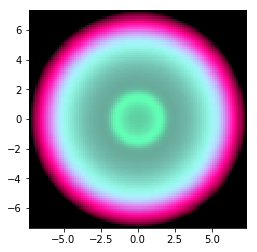

In [14]:
# Draw a 3 colors image:
MoutCMF.plot_3col()

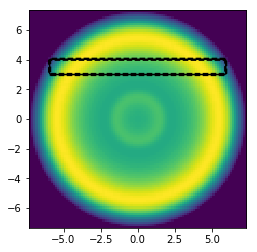

In [15]:
# Draw an image and the slit:
MoutCMF.plot_im('H__1_486136A')

(0.01, 1000.0)

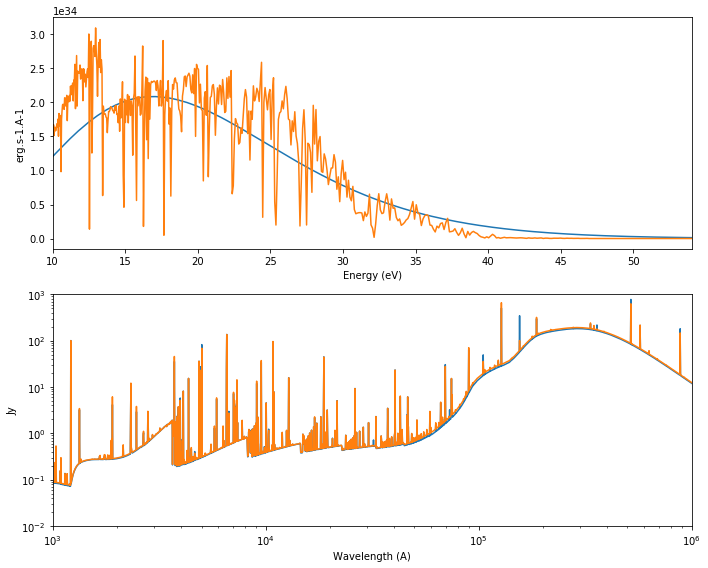

In [16]:
# Plot the continuum: top: The stellar continuum in the ionizing region
# bottom: the nebular+stellar in the UV+Opt+IR region
f, axes = plt.subplots(2, 1, figsize=(10,8))
MoutBB.plot_cont(axes=axes)
MoutCMF.plot_cont(axes=axes)
axes[1].set_ylim((1e-2, 1e3))

## Computing line profiles

Assume that the nebula is expanding with a given velocity law.

### Draw the profiles of the H$\beta$, [O II] $\lambda$ 3727, and [O III] $\lambda$ 5007lines as would be observed with a pencil beam passing trough the center, for a constant expanding velocity, for a velocity increasing linearly with the radius and for a velocity increasing with the suqared radius.

### Compute the line profiles as would be observed by a long slit along the symmetry axis, with a beam shifted by 5 arcsec from the center and for the full nebula (for the ”Hubble flow” expanding nebula.

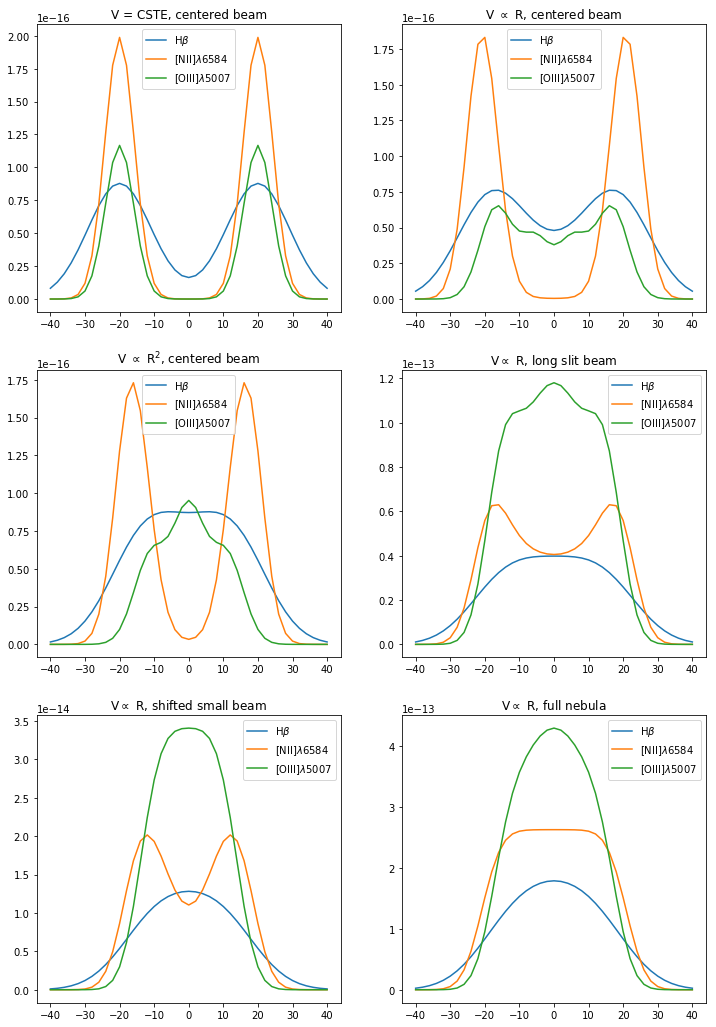

In [17]:
f, axes = plt.subplots(3, 2, figsize=(12,18))

MoutCMF.define_profiles(size_spectrum = 41,vel_max = 40, vel_params=[20.,0.,0])
MoutCMF.plot_profile(ax=axes[0,0], title='V = CSTE, centered beam')

MoutCMF.define_profiles(size_spectrum = 41,vel_max = 40, vel_params=[0.,40.,0])
MoutCMF.plot_profile(ax=axes[0,1], title=r'V $\propto$ R, centered beam')

MoutCMF.define_profiles(size_spectrum = 41,vel_max = 40, vel_params=[0.,0.,60])
MoutCMF.plot_profile(ax=axes[1,0], title=r'V $\propto$ R$^2$, centered beam')

MoutCMF.define_profiles(size_spectrum = 41,vel_max = 40, vel_params=[0.,40.,0])
MoutCMF.mask = None
MoutCMF.mask_ap_size = (30., 3.)
MoutCMF.mask_ap_center = (0., 0.)
MoutCMF.plot_profile(ax=axes[1,1], use_mask=True, 
                     title=r'V$\propto$ R, long slit beam')

MoutCMF.mask = None
MoutCMF.mask_ap_size = (3., 3.)
MoutCMF.mask_ap_center = (0., 5.)
MoutCMF.plot_profile(ax=axes[2,0], use_mask=True,
                     title=r'V$\propto$ R, shifted small beam')

MoutCMF.mask = None
MoutCMF.mask_ap_size = (30., 30.)
MoutCMF.mask_ap_center = (0., 0.)
MoutCMF.plot_profile(ax=axes[2,1], use_mask=True,
                     title=r'V$\propto$ R, full nebula')

### ??? Comments

In [18]:
# the following is to have the nice style in the Notebook.
# Don't remove this.
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()